# 0. Imports & inputs & introductions

This files is written to compare the data sent from James Sturch to compare the mismatch results using Solar Edge system. The email was sent by Jame Sturch and the date was 20/11/2024.

In [12]:
# imports
import os
import sys
import time
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pvlib
import imageio
import datetime
from datetime import timedelta
import scipy.constants as const

# data folder direcotry
data_dir = r"C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Data"
# direrctory for saving results
base_dir = r"C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results"

In [13]:
# define the function to calculate the I0 at MPPT
def I0(I, V, Rs, Rsh, n, N, vth):
    # calculate the exponential term
    exp_term = np.exp(-(V + I * Rs) / (n * N * vth))
    # calculate the fraction term
    frac_term = n * N * vth / V
    # calculate hte numerator
    numerator = I*(1 + Rs/Rsh) - V/Rsh
    # calculate the denominator
    denominator = 1 - I * Rs / V
    # put them together
    I0 = numerator / denominator * frac_term * exp_term
    return I0

# define the function to calculate IL at MPPT
def IL(I, V, Rs, Rsh, n, N, vth, I0):
    # calculate the first term
    first_term = I * (1 + Rs/Rsh)
    # calculate the second term
    second_term = V / Rsh
    # calculate the third term
    third_term = I0*(np.exp((V + I * Rs) / (n * N * vth)) - 1)
    # put them together
    IL = first_term + second_term + third_term
    return IL


# 1. Read & visualise

## 1.1. Find the site

In [ ]:
# Define the site to read
site_id = '1398284'  # Site identifier
# site_id = '347166'

# define the season
season = 'summer'
# season = 'winter'

# Find the directory containing the site_id
site_dir = [d for d in os.listdir(data_dir) if site_id in d][0]

# Full path to the site directory
site_dir = os.path.join(data_dir, site_dir)


## 1.2. Season data extraction

### 1.2.1. Data extraction

In [15]:
# Find the folder that contains the word "summer"
summer_dir = [d for d in os.listdir(site_dir) if season in d][0]

# Full path to the summer directory
summer_dir = os.path.join(site_dir, summer_dir)

# Initialize an empty list to store the dataframes
dataframes = []
reporter_ids = []

# Loop through the files in the summer directory
for file in os.listdir(summer_dir):
    if 'optimizer_data' in file and file.endswith('.csv'):
        # Read the CSV file
        optimizer_data = pd.read_csv(os.path.join(summer_dir, file))

        # Extract the reporter_id from the file name
        reporter_id = file.split('_')[-1].split('.')[0]
        reporter_ids.append(reporter_id)

        # Rename the columns, including "power"
        optimizer_data.rename(columns={
            'panel_current': f'panel_current_{reporter_id}',
            'panel_voltage': f'panel_voltage_{reporter_id}',
            'temperature': f'temperature_{reporter_id}',
            'panel_temperature': f'panel_temperature_{reporter_id}',
            'power': f'power_{reporter_id}'
        }, inplace=True)


        # Rename the first column to "Timestamp"
        optimizer_data.rename(columns={optimizer_data.columns[0]: 'Timestamp'}, inplace=True)

        # Set the "Timestamp" column as index
        optimizer_data.set_index('Timestamp', inplace=True)

        # Drop any other columns except the renamed ones
        optimizer_data = optimizer_data[[f'panel_current_{reporter_id}',
                                         f'panel_voltage_{reporter_id}',
                                         f'temperature_{reporter_id}',
                                         f'panel_temperature_{reporter_id}',
                                         f'power_{reporter_id}']]

        # Append the dataframe to the list
        dataframes.append(optimizer_data)

# make sure all files have the same Timestamps
timestamps = [df.index for df in dataframes]
if not all([timestamps[0].equals(ts) for ts in timestamps]):
    print('Timestamps are not the same')
    # force them to be the same by taking the intersection
    common_timestamps = timestamps[0]
    for ts in timestamps[1:]:
        common_timestamps = common_timestamps.intersection(ts)
    # filter the dataframes
    for i, df in enumerate(dataframes):
        dataframes[i] = df.loc[common_timestamps]
    

# Merge all dataframes on the "Timestamp" index
if dataframes:
    merged_data = pd.concat(dataframes, axis=1)

# Reset the index for a clean dataframe
merged_data.reset_index(inplace=True)

# Remove rows with NaN values
merged_data.dropna(inplace=True)

# print the merged data
print(merged_data)


Timestamps are not the same
                Timestamp  panel_current_99669233  panel_voltage_99669233  \
0     2024-01-10 06:50:00                0.187500               30.301064   
1     2024-01-10 06:55:00                0.195477               30.864309   
2     2024-01-10 07:00:00                0.225759               30.313084   
3     2024-01-10 07:05:00                0.256033               29.552083   
4     2024-01-10 07:10:00                0.253846               30.903846   
...                   ...                     ...                     ...   
1636  2024-01-19 20:00:00                0.730236               30.903153   
1637  2024-01-19 20:05:00                0.769808               33.947661   
1638  2024-01-19 20:10:00                0.402325               34.365256   
1639  2024-01-19 20:15:00                0.248558               28.182692   
1640  2024-01-19 20:20:00                0.181250               26.500000   

      temperature_99669233  panel_temperature_9

In [16]:
# import pandas as pd
# import os

# # Find the folder that contains the word "summer"
# summer_dir = [d for d in os.listdir(site_dir) if season in d][0]

# # Full path to the summer directory
# summer_dir = os.path.join(site_dir, summer_dir)

# # Initialize an empty list to store the DataFrames
# dataframes = []
# reporter_ids = []

# # Define a list of potential timestamp formats
# timestamp_formats = [
#     "%Y-%m-%d %H:%M:%S",
#     "%d/%m/%Y %H:%M",
#     "%m/%d/%Y %H:%M",
#     "%Y-%d-%m %H:%M:%S",
#     None  # Let pandas infer formats
# ]

# # Loop through the files in the summer directory
# for file in os.listdir(summer_dir):
#     if 'optimizer_data' in file and file.endswith('.csv'):
#         # Read the CSV file
#         optimizer_data = pd.read_csv(os.path.join(summer_dir, file))

#         # Extract the reporter_id from the file name
#         reporter_id = file.split('_')[-1].split('.')[0]
#         reporter_ids.append(reporter_id)

#         # Rename the columns, including "power"
#         optimizer_data.rename(columns={
#             'panel_current': f'panel_current_{reporter_id}',
#             'panel_voltage': f'panel_voltage_{reporter_id}',
#             'temperature': f'temperature_{reporter_id}',
#             'panel_temperature': f'panel_temperature_{reporter_id}',
#             'power': f'power_{reporter_id}'
#         }, inplace=True)

#         # Rename the first column to "Timestamp"
#         optimizer_data.rename(columns={optimizer_data.columns[0]: 'Timestamp'}, inplace=True)

#         # Convert the timestamp to datetime
#         for fmt in timestamp_formats:
#             try:
#                 optimizer_data['Timestamp'] = pd.to_datetime(optimizer_data['Timestamp'], format=fmt)
#                 break
#             except ValueError:
#                 pass

#         # Collect it into the list
#         dataframes.append(optimizer_data)

# # Extract the reference timestamps from the first dataframe
# reference_timestamps = dataframes[0]['Timestamp']

# # Synchronize timestamps across all dataframes
# synchronized_dataframes = []
# for df in dataframes:
#     # Set 'Timestamp' as index for alignment
#     df.set_index('Timestamp', inplace=True)

#     # Reindex to match the reference timestamps
#     df = df.reindex(reference_timestamps)

#     # Fill missing data with zeros
#     df.fillna(0, inplace=True)

#     # Reset index back to a column
#     df.reset_index(inplace=True)
#     df.rename(columns={'index': 'Timestamp'}, inplace=True)

#     # Add to synchronized list
#     synchronized_dataframes.append(df)

# # The synchronized_dataframes now contain aligned data
# # Optionally, concatenate into a single DataFrame
# final_dataframe = pd.concat(synchronized_dataframes, axis=1)

# # rename it as merged_data
# merged_data = final_dataframe

# print(merged_data)


### 1.2.2. Visualisation

                Timestamp  panel_current_99669233  panel_voltage_99669233  \
0     2024-01-10 06:50:00                0.187500               30.301064   
1     2024-01-10 06:55:00                0.195477               30.864309   
2     2024-01-10 07:00:00                0.225759               30.313084   
3     2024-01-10 07:05:00                0.256033               29.552083   
4     2024-01-10 07:10:00                0.253846               30.903846   
...                   ...                     ...                     ...   
1145  2024-01-16 19:50:00                0.203835               26.232955   
1146  2024-01-16 19:55:00                0.168703               26.138565   
1147  2024-01-16 20:00:00                0.168608               26.166063   
1148  2024-01-16 20:05:00                0.168514               26.193561   
1149  2024-01-17 06:45:00                0.156377               29.713245   

      temperature_99669233  panel_temperature_99669233  power_99669233  \
0

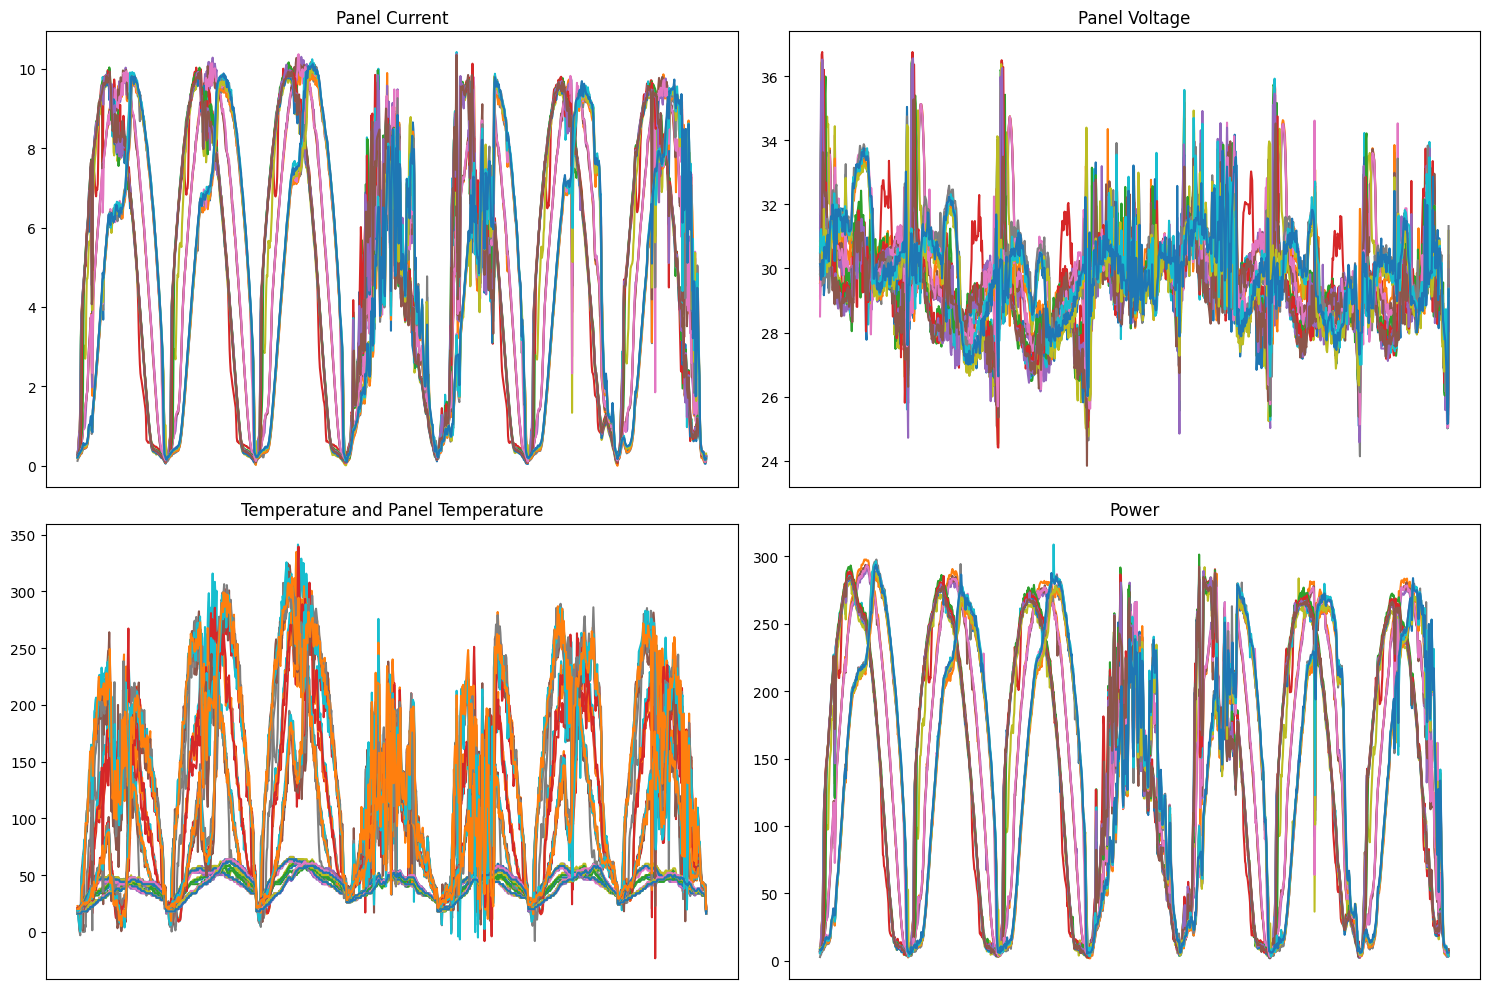

In [17]:
# Specify the number of days to plot
num_days_to_plot = 7


# Filter the data for the specified number of days
start_date = pd.to_datetime(merged_data['Timestamp'].iloc[0])
end_date = start_date + timedelta(days=num_days_to_plot)
filtered_data = merged_data[(pd.to_datetime(merged_data['Timestamp']) >= start_date) & 
                            (pd.to_datetime(merged_data['Timestamp']) < end_date)]

print(filtered_data)

# Create a 2x2 subplot for the data
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot all panel currents
for reporter_id in reporter_ids:
    axs[0, 0].plot(filtered_data['Timestamp'], filtered_data[f'panel_current_{reporter_id}'])
axs[0, 0].set_title('Panel Current')
axs[0, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-ticks

# Plot all panel voltages
for reporter_id in reporter_ids:
    axs[0, 1].plot(filtered_data['Timestamp'], filtered_data[f'panel_voltage_{reporter_id}'])
axs[0, 1].set_title('Panel Voltage')
axs[0, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-ticks

# Plot all temperatures and panel temperatures together
for reporter_id in reporter_ids:
    axs[1, 0].plot(filtered_data['Timestamp'], filtered_data[f'temperature_{reporter_id}'])
    axs[1, 0].plot(filtered_data['Timestamp'], filtered_data[f'panel_temperature_{reporter_id}'])
axs[1, 0].set_title('Temperature and Panel Temperature')
axs[1, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-ticks

# Plot all powers
for reporter_id in reporter_ids:
    axs[1, 1].plot(filtered_data['Timestamp'], filtered_data[f'power_{reporter_id}'])
axs[1, 1].set_title('Power')
axs[1, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-ticks

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# 2. Series connection power calculation

## 2.1. One diode model data extraction

The data of module they get it from PVsyst database, which is CS6K - 315MS from CSI Solar. Therefore I go to PVsyst, find the module and extract n, Ncell, Rs, Rsh, then put it below.

In [18]:
# Parameters for the one-diode model
ideality_factor = 1.015
num_cells_series = 60
thermal_voltage_25C = 0.0258
series_resistance = 0.27
shunt_resistance = 700

# Option to dynamically calculate vth based on panel temperature
use_dynamic_vth = True  # Set to True to enable dynamic calculation, False to use thermal_voltage_25C

# # Constants for vth calculation
boltzmann_constant = const.Boltzmann  # Boltzmann constant in J/K
electron_charge = const.e  # Elementary charge in C

## 2.2. Calculate IV curves from MPPT

In [19]:
# Get the current timestamp when the code is run
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = os.path.join(base_dir, f'v_from_i/iv_curve_plots_{timestamp}_{season}_{site_id}')
os.makedirs(output_dir, exist_ok=True)

# List to keep track of file paths for the GIF
image_files = []

# Determine fixed x and y axis limits for all plots
y_limit = (0, 12)
x_limit = (0, 25)  # Assuming a reasonable range for combined voltages

# Generate a range of currents for plotting the IV curve
currents = np.linspace(0, y_limit[1], 100)

# Loop through each time step
for idx in range(len(merged_data)):

    # Create a new figure for each time step
    plt.figure(figsize=(10, 6))

    # Initialize a counter for the number of IV curves in the plot
    iv_curve_count = 0

    # Check if this row contains any NaN or zero
    is_nan_or_zero = merged_data.iloc[idx].isnull().values.any() or (merged_data.iloc[idx] == 0).values.any()
    if is_nan_or_zero:
        print(f"Time step {idx} contains NaN or zero values, plotting zero voltage IV curves.")

    # Loop through each optimiser
    for optimiser in reporter_ids:
        
        # Extract the IV data from the optimiser for the current time step
        optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
        optimiser_current = merged_data[f'panel_current_{optimiser}']
        panel_temperature = merged_data[f'panel_temperature_{optimiser}']  # Panel temperature in °C

        if is_nan_or_zero:
            # If there are NaN or zero values, set voltage to zero for the entire current range
            voltage = np.zeros_like(currents)
            plt.plot(voltage, currents, label=f'Optimizer {optimiser}')
        else:
            # Convert panel temperature to Kelvin
            panel_temperature_kelvin = panel_temperature.iloc[idx] + 273.15

            # Calculate vth dynamically or use the fixed value
            if use_dynamic_vth:
                vth = boltzmann_constant * panel_temperature_kelvin / electron_charge
            else:
                vth = thermal_voltage_25C

            # Extract voltage and current for the current time step
            panel_voltage = optimiser_voltage.iloc[idx] / 2
            panel_current = optimiser_current.iloc[idx]

            # Calculate the I0 at the operating point for the current time step
            I0_op = I0(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth)

            # Calculate the IL at the operating point for the current time step
            IL_op = IL(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth, I0_op)

            # Use the single diode model to calculate voltage for each current point
            params = {
                'photocurrent': IL_op,  # Photocurrent (light-generated current)
                'saturation_current': I0_op,  # Saturation current
                'resistance_series': series_resistance,  # Series resistance
                'resistance_shunt': shunt_resistance,  # Shunt resistance
                'nNsVth': ideality_factor * num_cells_series * vth  # Ideality factor * Cells in series * Thermal voltage
            }

            # Calculate voltage for each current point using the single diode model
            voltage = pvlib.pvsystem.v_from_i(
                current=currents,
                photocurrent=params['photocurrent'],
                saturation_current=params['saturation_current'],
                resistance_series=params['resistance_series'],
                resistance_shunt=params['resistance_shunt'],
                nNsVth=params['nNsVth']
            )

            # Plot the IV curve for the current time step on the same axis
            plt.plot(voltage, currents, label=f'Optimizer {optimiser}')

            # Mark the panel voltage and panel current at this point
            plt.plot(panel_voltage, panel_current, 'ro')  # Mark with a red circle

        # Increment the counter for each plotted IV curve
        iv_curve_count += 1

    # Print out the number of IV curves in the plot
    print(f"Time step {idx} has {iv_curve_count} IV curves plotted.")

    # Set consistent x and y axis limits for all plots
    plt.xlim(x_limit)
    plt.ylim(y_limit)

    # Finalize the plot for the current time step
    plt.xlabel('Voltage (V)')
    plt.ylabel('Current (A)')
    # Use the timestamp from the current row as the title
    timestamp_title = pd.to_datetime(merged_data['Timestamp'].iloc[idx]).strftime('%Y-%m-%d %H:%M:%S')
    plt.title(f'IV Curves at {timestamp_title}')
    plt.grid(True)

    # Save the plot as a PNG file with "summer/winter" and site_id in the file name
    file_path = os.path.join(output_dir, f'iv_curve_{timestamp_title.replace(":", "-").replace(" ", "_")}.png')
    plt.savefig(file_path)
    plt.close()

    # Add the file path to the list for GIF creation
    image_files.append(file_path)

# Create a GIF from the saved images with slower speed and loop indefinitely
gif_path = os.path.join(output_dir, f'iv_curves_{season}_{site_id}.gif')
with imageio.get_writer(gif_path, mode='I', duration=200, loop=0) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"GIF saved as '{gif_path}'")


Time step 0 has 21 IV curves plotted.
Time step 1 has 21 IV curves plotted.
Time step 2 has 21 IV curves plotted.
Time step 3 has 21 IV curves plotted.
Time step 4 has 21 IV curves plotted.
Time step 5 has 21 IV curves plotted.
Time step 6 has 21 IV curves plotted.
Time step 7 has 21 IV curves plotted.
Time step 8 has 21 IV curves plotted.
Time step 9 has 21 IV curves plotted.
Time step 10 has 21 IV curves plotted.
Time step 11 has 21 IV curves plotted.
Time step 12 has 21 IV curves plotted.
Time step 13 has 21 IV curves plotted.
Time step 14 has 21 IV curves plotted.
Time step 15 has 21 IV curves plotted.
Time step 16 has 21 IV curves plotted.
Time step 17 has 21 IV curves plotted.
Time step 18 has 21 IV curves plotted.
Time step 19 has 21 IV curves plotted.
Time step 20 has 21 IV curves plotted.
Time step 21 has 21 IV curves plotted.
Time step 22 has 21 IV curves plotted.
Time step 23 has 21 IV curves plotted.
Time step 24 has 21 IV curves plotted.
Time step 25 has 21 IV curves plott

C:\Users\z5183876\AppData\Local\Temp\ipykernel_12996\426568947.py:117: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved as 'C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i/iv_curve_plots_20241212_074304_summer_1398284\iv_curves_summer_1398284.gif'


## 2.3. Combine IV curves in series

### 2.3.1. Without bypass

In [20]:
# # Get the current timestamp when the code is run
# timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
# output_dir = os.path.join(base_dir, f'v_from_i_combined/iv_curve_plots_{timestamp}')
# os.makedirs(output_dir, exist_ok=True)

# # List to keep track of file paths for the GIF
# image_files = []

# # DataFrame to store the maximum power points at each time step
# max_power_df_clip_i = pd.DataFrame(columns=['Time Step', 'Max Voltage (V)', 'Max Current (A)', 'Max Power (W)', 'Voc (V)', 'Isc (A)'])

# # Determine fixed x and y axis limits for all plots
# y_limit = (0, 13)
# x_limit = (0, 500)  # Adjust for combined voltages

# # Generate a range of currents for plotting the IV curve
# currents = np.linspace(0, y_limit[1], 100)

# # Debug: Print the output directory
# print(f"Output directory: {output_dir}")

# # Loop through each time step
# for idx in range(len(merged_data)):

#     # Create a new figure for each time step
#     plt.figure(figsize=(10, 6))

#     # Initialize array to store summed voltages for combined IV curve
#     combined_voltage = np.zeros_like(currents)

#     # Check if this row contains any NaN or zero
#     is_nan_or_zero = merged_data.iloc[idx].isnull().values.any() or (merged_data.iloc[idx] == 0).values.any()
#     if is_nan_or_zero:
#         print(f"Time step {idx} contains NaN or zero values, skipping combined IV curve.")
#         zero_power = pd.DataFrame({
#             'Time Step': [idx],
#             'Max Voltage (V)': [0],
#             'Max Current (A)': [0],
#             'Max Power (W)': [0],
#             'Voc (V)': [0],
#             'Isc (A)': [0]
#         })
#         max_power_df_clip_i = pd.concat([max_power_df_clip_i, zero_power], ignore_index=True)
#         continue

#     # Get the smallest Isc value from the dataset for the current time step across all optimisers
#     smallest_isc = merged_data.iloc[idx][[f'panel_current_{optimiser}' for optimiser in reporter_ids]].min()

#     # Loop through each optimiser
#     for optimiser in reporter_ids:
#         # Extract the IV data from the optimiser for the current time step
#         optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
#         optimiser_current = merged_data[f'panel_current_{optimiser}']
#         panel_temperature = merged_data[f'panel_temperature_{optimiser}']  # Panel temperature in °C

#         if is_nan_or_zero:
#             continue

#         # Convert panel temperature to Kelvin
#         panel_temperature_kelvin = panel_temperature.iloc[idx] + 273.15

#         # Calculate vth dynamically or use the fixed value
#         if use_dynamic_vth:
#             vth = boltzmann_constant * panel_temperature_kelvin / electron_charge
#         else:
#             vth = thermal_voltage_25C

#         # Extract voltage and current for the current time step
#         panel_voltage = optimiser_voltage.iloc[idx] / 2
#         panel_current = optimiser_current.iloc[idx]

#         # Check if panel_voltage and panel_current contain valid values
#         if np.isnan(panel_voltage) or np.isnan(panel_current):
#             print(f"NaN found in voltage/current at time step {idx}, optimiser {optimiser}")
#             continue

#         # Calculate I0 and IL for the optimiser at this time step
#         I0_op = I0(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth)
#         IL_op = IL(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth, I0_op)

#         # Use the single diode model to calculate voltage for each current point
#         params = {
#             'photocurrent': IL_op,  # Photocurrent (light-generated current)
#             'saturation_current': I0_op,  # Saturation current
#             'resistance_series': series_resistance,  # Series resistance
#             'resistance_shunt': shunt_resistance,  # Shunt resistance
#             'nNsVth': ideality_factor * num_cells_series * vth  # Ideality factor * Cells in series * Thermal voltage
#         }

#         # Calculate voltage for each current point using the single diode model
#         voltage = pvlib.pvsystem.v_from_i(
#             current=currents,
#             photocurrent=params['photocurrent'],
#             saturation_current=params['saturation_current'],
#             resistance_series=params['resistance_series'],
#             resistance_shunt=params['resistance_shunt'],
#             nNsVth=params['nNsVth']
#         )

#         # If current > smallest Isc, set voltage to 0 for those current values
#         voltage = np.where(currents > smallest_isc, 0, voltage)

#         # Add the voltage to the combined voltage array
#         combined_voltage += voltage

#     # Calculate power for each voltage point using the combined IV curve
#     power = combined_voltage * currents

#     # Find the index of the maximum power point
#     max_power_idx = np.argmax(power)
#     max_voltage = combined_voltage[max_power_idx]
#     max_current = currents[max_power_idx]
#     max_power = power[max_power_idx]

#     # Voc and Isc calculation
#     Voc = combined_voltage[-1]
#     Isc = smallest_isc

#     # Create a DataFrame for the current max power point
#     max_power_point = pd.DataFrame({
#         'Time Step': [idx],
#         'Max Voltage (V)': [max_voltage],
#         'Max Current (A)': [max_current],
#         'Max Power (W)': [max_power],
#         'Voc (V)': [Voc],
#         'Isc (A)': [Isc]
#     })

#     max_power_df_clip_i = pd.concat([max_power_df_clip_i, max_power_point], ignore_index=True)

#     # Plot the combined IV curve
#     plt.plot(combined_voltage, currents, label='Combined IV Curve')
#     plt.plot(max_voltage, max_current, 'ro', label='Max Power Point')

#     plt.xlim(x_limit)
#     plt.ylim(y_limit)
#     plt.xlabel('Voltage (V)')
#     plt.ylabel('Current (A)')
#     plt.title(f'Combined IV Curves at Time Step {idx}')
#     plt.grid(True)
#     plt.legend()

#     # Save the plot as a PNG file
#     file_path = os.path.join(output_dir, f'combined_iv_curve_{idx}.png')
#     plt.savefig(file_path)
#     plt.close()

#     # Add the file path to the list for GIF creation
#     image_files.append(file_path)

# # Save the DataFrame to a CSV file
# csv_file = os.path.join(output_dir, 'max_power_points_with_voc_isc.csv')
# max_power_df_clip_i.to_csv(csv_file, index=False)
# print(f"CSV saved as: {csv_file}")

# # Create GIF
# gif_path = os.path.join(output_dir, 'combined_iv_curves.gif')
# with imageio.get_writer(gif_path, mode='I', duration=200, loop=0) as writer:
#     for filename in image_files:
#         image = imageio.imread(filename)
#         writer.append_data(image)

# print(f"GIF saved as: {gif_path}")


### 2.3.2. Ideal bypass

In [21]:
# # Get the current timestamp when the code is run
# timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
# output_dir = os.path.join(base_dir, f'v_from_i_combined/iv_curve_plots_{timestamp}_{season}_{site_id}')
# os.makedirs(output_dir, exist_ok=True)

# # List to keep track of file paths for the GIF
# image_files = []

# # DataFrame to store the maximum power points at each time step
# max_power_df_clip_i = pd.DataFrame(columns=['Time Step', 'Max Voltage (V)', 'Max Current (A)', 'Max Power (W)', 'Voc (V)', 'Isc (A)'])

# # Determine fixed x and y axis limits for all plots
# y_limit = (0, 13)
# x_limit = (0, 500)  # Adjust for combined voltages

# # Generate a range of currents for plotting the IV curve
# currents = np.linspace(0, y_limit[1], 100)

# # Debug: Print the output directory
# print(f"Output directory: {output_dir}")

# # Loop through each time step
# for idx in range(len(merged_data)):

#     # Create a new figure for each time step
#     plt.figure(figsize=(10, 6))

#     # Initialize array to store summed voltages for combined IV curve
#     combined_voltage = np.zeros_like(currents)

#     # Check if this row contains any NaN or zero
#     is_nan_or_zero = merged_data.iloc[idx].isnull().values.any() or (merged_data.iloc[idx] == 0).values.any()
#     if is_nan_or_zero:
#         print(f"Time step {idx} contains NaN or zero values, skipping combined IV curve.")
#         zero_power = pd.DataFrame({
#             'Time Step': [idx],
#             'Max Voltage (V)': [0],
#             'Max Current (A)': [0],
#             'Max Power (W)': [0],
#             'Voc (V)': [0],
#             'Isc (A)': [0]
#         })
#         max_power_df_clip_i = pd.concat([max_power_df_clip_i, zero_power], ignore_index=True)
#         continue

#     # Loop through each optimiser
#     for optimiser in reporter_ids:
#         # Extract the IV data from the optimiser for the current time step
#         optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
#         optimiser_current = merged_data[f'panel_current_{optimiser}']
#         panel_temperature = merged_data[f'panel_temperature_{optimiser}']  # Panel temperature in °C

#         if is_nan_or_zero:
#             continue

#         # Convert panel temperature to Kelvin
#         panel_temperature_kelvin = panel_temperature.iloc[idx] + 273.15

#         # Calculate vth dynamically or use the fixed value
#         if use_dynamic_vth:
#             vth = boltzmann_constant * panel_temperature_kelvin / electron_charge
#         else:
#             vth = thermal_voltage_25C

#         # Extract voltage and current for the current time step
#         panel_voltage = optimiser_voltage.iloc[idx] / 2
#         panel_current = optimiser_current.iloc[idx]

#         # Check if panel_voltage and panel_current contain valid values
#         if np.isnan(panel_voltage) or np.isnan(panel_current):
#             print(f"NaN found in voltage/current at time step {idx}, optimiser {optimiser}")
#             continue

#         # Calculate I0 and IL for the optimiser at this time step
#         I0_op = I0(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth)
#         IL_op = IL(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth, I0_op)

#         # Use the single diode model to calculate voltage for each current point
#         params = {
#             'photocurrent': IL_op,  # Photocurrent (light-generated current)
#             'saturation_current': I0_op,  # Saturation current
#             'resistance_series': series_resistance,  # Series resistance
#             'resistance_shunt': shunt_resistance,  # Shunt resistance
#             'nNsVth': ideality_factor * num_cells_series * vth  # Ideality factor * Cells in series * Thermal voltage
#         }

#         # Calculate voltage for each current point using the single diode model
#         voltage = pvlib.pvsystem.v_from_i(
#             current=currents,
#             photocurrent=params['photocurrent'],
#             saturation_current=params['saturation_current'],
#             resistance_series=params['resistance_series'],
#             resistance_shunt=params['resistance_shunt'],
#             nNsVth=params['nNsVth']
#         )

#         # Solve the single diode equation to get ISC, VOC, and PMPPT
#         results = pvlib.pvsystem.singlediode(
#             photocurrent=params['photocurrent'],
#             saturation_current=params['saturation_current'],
#             resistance_series=params['resistance_series'],
#             resistance_shunt=params['resistance_shunt'],
#             nNsVth=params['nNsVth']
#         )

#         # Extract Isc, Voc, and PMPPT
#         isc = results['i_sc']
#         voc = results['v_oc']
#         pmppt = results['p_mp']
#         vmppt = results['v_mp']
#         imppt = results['i_mp']

#         # If current > Isc, set voltage to 0 for those current values
#         voltage = np.where(currents > isc, 0, voltage)

#         # Add the voltage to the combined voltage array without clipping
#         combined_voltage += voltage

#     # Calculate power for each voltage point using the combined IV curve
#     power = combined_voltage * currents

#     # Find the index of the maximum power point
#     max_power_idx = np.argmax(power)
#     max_voltage = combined_voltage[max_power_idx]
#     max_current = currents[max_power_idx]
#     max_power = power[max_power_idx]

#     # Find the isc by taking the largest current vlaue in currents where the combined voltage is greater than zero
#     isc_string = currents[np.where(combined_voltage > 0)[0][-1]]
#     # Find the voc by taking voltage value in combined_voltage where the current is zero
#     voc_string = combined_voltage[np.where(currents == 0)[0][0]]

#     # Create a DataFrame for the current max power point
#     max_power_point = pd.DataFrame({
#         'Time Step': [idx],
#         'Max Voltage (V)': [max_voltage],
#         'Max Current (A)': [max_current],
#         'Max Power (W)': [max_power],
#         'Voc (V)': [voc_string],
#         'Isc (A)': [isc_string]
#     })

#     max_power_df_clip_i = pd.concat([max_power_df_clip_i, max_power_point], ignore_index=True)

#     # Plot the combined IV curve
#     plt.plot(combined_voltage, currents, label='Combined IV Curve')
#     plt.plot(max_voltage, max_current, 'ro', label='Max Power Point')
#     plt.plot(voc_string, 0, 'go', label='Voc')
#     plt.plot(0, isc_string, 'bo', label='Isc')

#     # Add PMPPT, VMPPT, and IMPPT to the title
#     timestamp_title = pd.to_datetime(merged_data['Timestamp'].iloc[idx]).strftime('%Y-%m-%d %H:%M:%S')
#     plt.title(
#         f"Combined IV Curves at {timestamp_title}\n"
#         f"Pmppt: {max_power:.2f} W, Vmppt: {max_voltage:.2f} V, Imppt: {max_current:.2f} A"
#     )

#     plt.xlim(x_limit)
#     plt.ylim(y_limit)
#     plt.xlabel('Voltage (V)')
#     plt.ylabel('Current (A)')
#     plt.grid(True)
#     plt.legend()

#     # Save the plot as a PNG file
#     file_path = os.path.join(output_dir, f'combined_iv_curve_{idx}.png')
#     plt.savefig(file_path)
#     plt.close()

#     # Add the file path to the list for GIF creation
#     image_files.append(file_path)

# # Save the DataFrame to a CSV file
# csv_file = os.path.join(output_dir, 'max_power_points_with_voc_isc.csv')
# max_power_df_clip_i.to_csv(csv_file, index=False)
# print(f"CSV saved as: {csv_file}")

# # Create GIF
# gif_path = os.path.join(output_dir, 'combined_iv_curves.gif')
# with imageio.get_writer(gif_path, mode='I', duration=200, loop=0) as writer:
#     for filename in image_files:
#         image = imageio.imread(filename)
#         writer.append_data(image)

# print(f"GIF saved as: {gif_path}")

In [22]:
# Get the current timestamp when the code is run
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = os.path.join(base_dir, f'v_from_i_combined/iv_curve_plots_{timestamp}_{season}_{site_id}')
os.makedirs(output_dir, exist_ok=True)

# List to keep track of file paths for the GIF
image_files = []

# DataFrame to store the maximum power points at each timestamp
max_power_df_clip_i = pd.DataFrame(columns=['Timestamp', 'Max Voltage (V)', 'Max Current (A)', 'Max Power (W)', 'Voc (V)', 'Isc (A)'])

# Determine fixed x and y axis limits for all plots
y_limit = (0, 13)
x_limit = (0, 500)  # Adjust for combined voltages

# Generate a range of currents for plotting the IV curve
currents = np.linspace(0, y_limit[1], 100)

# Debug: Print the output directory
print(f"Output directory: {output_dir}")

# Loop through each timestamp
for idx in range(len(merged_data)):

    # Create a new figure for each timestamp
    plt.figure(figsize=(10, 6))

    # Initialize array to store summed voltages for combined IV curve
    combined_voltage = np.zeros_like(currents)

    # Check if this row contains any NaN or zero
    is_nan_or_zero = merged_data.iloc[idx].isnull().values.any() or (merged_data.iloc[idx] == 0).values.any()
    current_timestamp = pd.to_datetime(merged_data['Timestamp'].iloc[idx])  # Extract current timestamp
    if is_nan_or_zero:
        print(f"Timestamp {current_timestamp} contains NaN or zero values, skipping combined IV curve.")
        zero_power = pd.DataFrame({
            'Timestamp': [current_timestamp],
            'Max Voltage (V)': [0],
            'Max Current (A)': [0],
            'Max Power (W)': [0],
            'Voc (V)': [0],
            'Isc (A)': [0]
        })
        max_power_df_clip_i = pd.concat([max_power_df_clip_i, zero_power], ignore_index=True)
        continue

    # Loop through each optimiser
    for optimiser in reporter_ids:
        # Extract the IV data from the optimiser for the current timestamp
        optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
        optimiser_current = merged_data[f'panel_current_{optimiser}']
        panel_temperature = merged_data[f'panel_temperature_{optimiser}']  # Panel temperature in °C

        if is_nan_or_zero:
            continue

        # Convert panel temperature to Kelvin
        panel_temperature_kelvin = panel_temperature.iloc[idx] + 273.15

        # Calculate vth dynamically or use the fixed value
        if use_dynamic_vth:
            vth = boltzmann_constant * panel_temperature_kelvin / electron_charge
        else:
            vth = thermal_voltage_25C

        # Extract voltage and current for the current timestamp
        panel_voltage = optimiser_voltage.iloc[idx] / 2
        panel_current = optimiser_current.iloc[idx]

        # Check if panel_voltage and panel_current contain valid values
        if np.isnan(panel_voltage) or np.isnan(panel_current):
            print(f"NaN found in voltage/current at timestamp {current_timestamp}, optimiser {optimiser}")
            continue

        # Calculate I0 and IL for the optimiser at this timestamp
        I0_op = I0(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth)
        IL_op = IL(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth, I0_op)

        # Use the single diode model to calculate voltage for each current point
        params = {
            'photocurrent': IL_op,  # Photocurrent (light-generated current)
            'saturation_current': I0_op,  # Saturation current
            'resistance_series': series_resistance,  # Series resistance
            'resistance_shunt': shunt_resistance,  # Shunt resistance
            'nNsVth': ideality_factor * num_cells_series * vth  # Ideality factor * Cells in series * Thermal voltage
        }

        # Calculate voltage for each current point using the single diode model
        voltage = pvlib.pvsystem.v_from_i(
            current=currents,
            photocurrent=params['photocurrent'],
            saturation_current=params['saturation_current'],
            resistance_series=params['resistance_series'],
            resistance_shunt=params['resistance_shunt'],
            nNsVth=params['nNsVth']
        )

        # Solve the single diode equation to get ISC, VOC, and PMPPT
        results = pvlib.pvsystem.singlediode(
            photocurrent=params['photocurrent'],
            saturation_current=params['saturation_current'],
            resistance_series=params['resistance_series'],
            resistance_shunt=params['resistance_shunt'],
            nNsVth=params['nNsVth']
        )

        # Extract Isc, Voc, and PMPPT
        isc = results['i_sc']
        voc = results['v_oc']
        pmppt = results['p_mp']
        vmppt = results['v_mp']
        imppt = results['i_mp']

        # If current > Isc, set voltage to 0 for those current values
        voltage = np.where(currents > isc, 0, voltage)

        # Add the voltage to the combined voltage array without clipping
        combined_voltage += voltage

    # Calculate power for each voltage point using the combined IV curve
    power = combined_voltage * currents

    # Find the index of the maximum power point
    max_power_idx = np.argmax(power)
    max_voltage = combined_voltage[max_power_idx]
    max_current = currents[max_power_idx]
    max_power = power[max_power_idx]

    # Find the isc by taking the largest current value in currents where the combined voltage is greater than zero
    isc_string = currents[np.where(combined_voltage > 0)[0][-1]]
    # Find the voc by taking voltage value in combined_voltage where the current is zero
    voc_string = combined_voltage[np.where(currents == 0)[0][0]]

    # Create a DataFrame for the current max power point
    max_power_point = pd.DataFrame({
        'Timestamp': [current_timestamp],
        'Max Voltage (V)': [max_voltage],
        'Max Current (A)': [max_current],
        'Max Power (W)': [max_power],
        'Voc (V)': [voc_string],
        'Isc (A)': [isc_string]
    })

    max_power_df_clip_i = pd.concat([max_power_df_clip_i, max_power_point], ignore_index=True)

    # Plot the combined IV curve
    plt.plot(combined_voltage, currents, label='Combined IV Curve')
    plt.plot(max_voltage, max_current, 'ro', label='Max Power Point')
    plt.plot(voc_string, 0, 'go', label='Voc')
    plt.plot(0, isc_string, 'bo', label='Isc')

    # Add PMPPT, VMPPT, and IMPPT to the title
    plt.title(
        f"Combined IV Curves at {current_timestamp}\n"
        f"Pmppt: {max_power:.2f} W, Vmppt: {max_voltage:.2f} V, Imppt: {max_current:.2f} A"
    )

    plt.xlim(x_limit)
    plt.ylim(y_limit)
    plt.xlabel('Voltage (V)')
    plt.ylabel('Current (A)')
    plt.grid(True)
    plt.legend()

    # Save the plot as a PNG file
    file_path = os.path.join(output_dir, f'combined_iv_curve_{current_timestamp.strftime("%Y%m%d_%H%M%S")}.png')
    plt.savefig(file_path)
    plt.close()

    # Add the file path to the list for GIF creation
    image_files.append(file_path)

# Save the DataFrame to a CSV file
csv_file = os.path.join(output_dir, 'max_power_points_with_voc_isc.csv')
max_power_df_clip_i.to_csv(csv_file, index=False)
print(f"CSV saved as: {csv_file}")

# Create GIF
gif_path = os.path.join(output_dir, 'combined_iv_curves.gif')
with imageio.get_writer(gif_path, mode='I', duration=200, loop=0) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"GIF saved as: {gif_path}")

Output directory: C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20241212_074929_summer_1398284
Timestamp 2024-01-17 18:25:00 contains NaN or zero values, skipping combined IV curve.
Timestamp 2024-01-19 20:20:00 contains NaN or zero values, skipping combined IV curve.
CSV saved as: C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20241212_074929_summer_1398284\max_power_points_with_voc_isc.csv


C:\Users\z5183876\AppData\Local\Temp\ipykernel_12996\2318853316.py:182: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved as: C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20241212_074929_summer_1398284\combined_iv_curves.gif


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

# 3. Power comparison

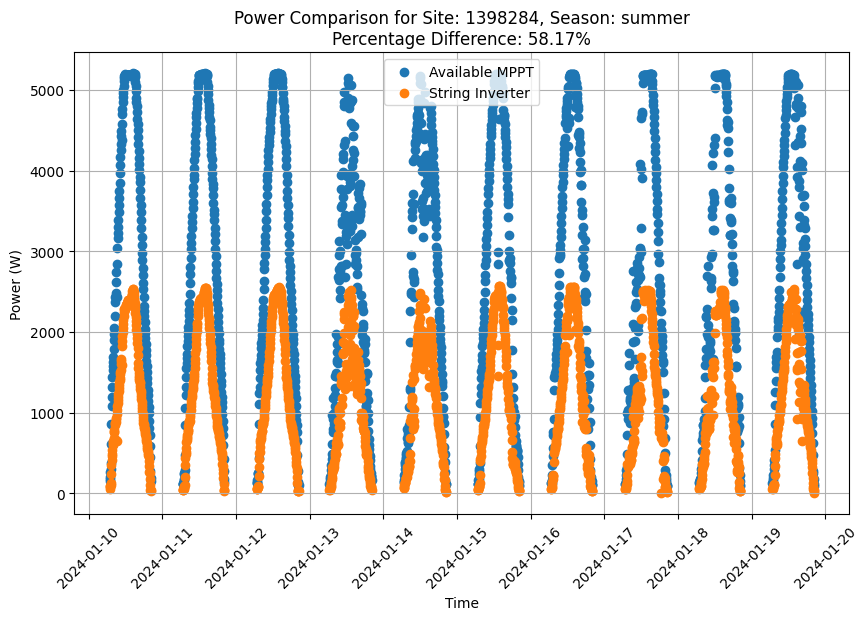

In [23]:
# If max_power_df_clip_i is not defined
if 'max_power_df_clip_i' not in locals():
    # Find the most recent folder in output_dir + 'v_from_i_combined'
    read_dir = os.path.join(base_dir, 'v_from_i_combined')
    # Find folders where the whole name contains the season and site_id
    folders = [os.path.join(read_dir, d) for d in os.listdir(read_dir) if season in d and site_id in d]
    if not folders:
        raise FileNotFoundError(f"No folders found for season {season} and site_id {site_id} in {read_dir}")
    # Find the most recent folder
    most_recent_folder = max(folders, key=os.path.getmtime)
    # Find the csv file in the most recent folder
    csv_file = [f for f in os.listdir(most_recent_folder) if f.endswith('.csv')][0]
    # Read the csv file
    max_power_df_clip_i = pd.read_csv(os.path.join(most_recent_folder, csv_file))

# Ensure both Timestamp columns are in datetime format
merged_data['Timestamp'] = pd.to_datetime(merged_data['Timestamp'])
max_power_df_clip_i['Timestamp'] = pd.to_datetime(max_power_df_clip_i['Timestamp'])

# Merge the two DataFrames based on the Timestamp column
power_compare_df = pd.merge(merged_data, max_power_df_clip_i, left_on='Timestamp', right_on='Timestamp', how='outer')

# Fill any gaps with 0 for all relevant columns
power_compare_df.fillna(0, inplace=True)

# Sum over the columns that start with 'power_' and end with a digit
power_compare_df['solar edge power'] = power_compare_df.filter(regex='power_\\d').sum(axis=1)

# Rename the Max Power (W) column to 'string inverter power'
if 'Max Power (W)' in power_compare_df.columns:
    power_compare_df.rename(columns={'Max Power (W)': 'string inverter power'}, inplace=True)

# Plot the power comparison
plt.figure(figsize=(10, 6))
plt.scatter(power_compare_df['Timestamp'], power_compare_df['solar edge power'], label='Available MPPT')
plt.scatter(power_compare_df['Timestamp'], power_compare_df['string inverter power'], label='String Inverter')
plt.xlabel('Time')
plt.ylabel('Power (W)')
plt.legend()
plt.grid(True)
# Rotate x-ticks by 45 degrees
plt.xticks(rotation=45)
# Sum up the two columns and calculate the percentage difference, then put it into the title
total_solar_edge_power = power_compare_df['solar edge power'].sum()
total_string_inverter_power = power_compare_df['string inverter power'].sum()
percentage_diff = (total_solar_edge_power - total_string_inverter_power) / total_solar_edge_power * 100
# Add site_id and season to the title
plt.title(f'Power Comparison for Site: {site_id}, Season: {season}\nPercentage Difference: {percentage_diff:.2f}%')
plt.show()